<h1>Tensorflow Object Detection API Menggunakan Google Colab <br>(Kasus: Deteksi Covid-19 Dari Data Rontgen Dada)<h1>

<h5>Referensi:</h5>
<ul>
  <li>
    luchoiunigo - 
    <a href="https://github.com/luchonaveiro/covid-19-xray.git" target="_blank">
      https://github.com/luchonaveiro/covid-19-xray.git
    </a>
  </li>
</ul>

<h2>Kelompok 7</h2>
<h5>Nama Kelompok:</h5>
<ul>
  <li>1. Muhammad Erlangga Gunawan - I.2210161</li>
  <li>2. Gerald Dwight Andgha C - I.2210326</li>
  <li>3. Riko Wahyudi - I.2210473</li>
  <li>4. Muhamad Taufiqurrahman - I.2211117</li>
</ul>

<h5>Dataset:</h5>
<ul>
  <li>
    Normal Dataset - 
    <a href="https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia" target="_blank">
      https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia
    </a>
  </li>
  <li>
    Covid Dataset - 
    <a href="https://github.com/ieee8023/covid-chestxray-dataset" target="_blank">
      https://github.com/ieee8023/covid-chestxray-dataset
    </a>
  </li>
</ul>

<h5>Deskripsi Singkat:</h5>
<p>
Notebook ini bertujuan untuk melakukan klasifikasi gambar rontgen dada menggunakan model deep learning seperti MobileNet.<br>
Model ini dibangun dan dilatih menggunakan TensorFlow sebagai framework utama untuk pemrosesan dan pelatihan model deep learning,<br> 
dengan tujuan membedakan antara gambar normal dan COVID-19 menggunakan dataset dari Kaggle dan GitHub.
</p>


## Langkah 1: Import Library yang Dibutuhkan
Kode berikut mengimpor semua library yang diperlukan untuk memproses data, membangun model, dan melakukan analisis hasil.<br> Library mencakup TensorFlow untuk deep learning, matplotlib untuk visualisasi, dan sklearn untuk evaluasi model.


In [1]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
import json
from PIL import Image
from IPython.display import Image as disp_image 
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt 

## Langkah 2: Menyiapkan Dataset dan Augmentasi Gambar

Pada langkah ini, kita mengonfigurasi parameter seperti ukuran gambar, batch size, dan epoch.<br>
Kemudian, menggunakan `ImageDataGenerator` untuk augmentasi gambar pada dataset pelatihan dan pengujian.<br> 
Dataset pelatihan dibagi menjadi training dan validation, sedangkan dataset pengujian hanya di-rescale tanpa augmentasi.


In [2]:
img_height = 128
img_width = 128
channels = 3
batch_size = 32
epochs = 10

train_datagen = ImageDataGenerator(rotation_range=40,
                                   rescale=1./255,
                                   zoom_range=0.1,
                                   validation_split=0.2)
                                
test_datagen = ImageDataGenerator(rescale=1./255)

training_set = train_datagen.flow_from_directory(
    './dataset/train',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode = 'binary',
    subset = 'training',
    shuffle = True
)

validation_set = train_datagen.flow_from_directory(
    './dataset/train',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode = 'binary',
    subset = 'validation',
    shuffle = False
)

test_set = test_datagen.flow_from_directory(
    './dataset/test',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    shuffle = False,
    class_mode = 'binary'
)

print(training_set.class_indices)

Found 1544 images belonging to 2 classes.
Found 386 images belonging to 2 classes.
Found 327 images belonging to 2 classes.
{'covid': 0, 'normal': 1}



- **Training set**: 1544 gambar dengan dua kelas (`covid` dan `normal`).
- **Validation set**: 386 gambar untuk validasi.
- **Test set**: 327 gambar untuk pengujian.
- Kelas yang digunakan adalah `covid` dan `normal`, dengan masing-masing diberi label 0 dan 1.


## Langkah 3: Menampilkan Gambar Rontgen

Pada langkah ini, kita menampilkan gambar rontgen untuk kedua kelas: **Normal** dan **COVID-19**.<br> Gambar diambil secara acak dari folder dataset yang telah dipersiapkan sebelumnya.


### Gambar Rontgen Normal
Berikut adalah contoh gambar rontgen yang termasuk dalam kelas **Normal**:


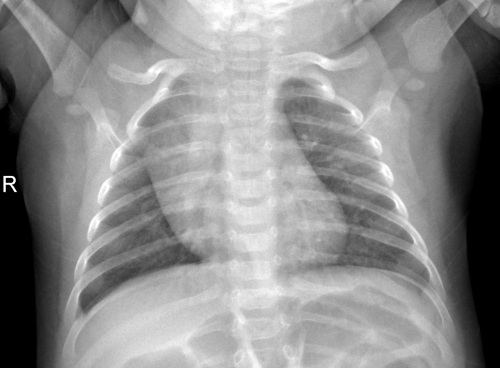

In [3]:
# Gambar rontgen normal
img_files = os.listdir('dataset/train/normal')
img_path = img_files[np.random.randint(0,len(img_files))]

img = Image.open('dataset/train/normal/{}'.format(img_path))
img.thumbnail((500, 500))
display(img)


### Gambar Rontgen COVID-19
Berikut adalah contoh gambar rontgen yang termasuk dalam kelas **COVID-19**:


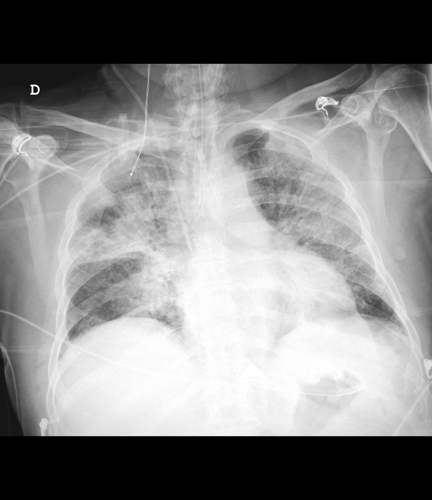

In [5]:
# Gambar rontgen covid
img_files = os.listdir('dataset/train/covid')
img_path = img_files[np.random.randint(0,len(img_files))]

img = Image.open('dataset/train/covid/{}'.format(img_path))
img.thumbnail((500, 500))
display(img)

## Langkah 4: Menyusun Model Klasifikasi dengan MobileNet

Membangun model klasifikasi menggunakan **MobileNet** sebagai feature extractor dan menambahkan lapisan untuk mengklasifikasikan gambar menjadi **COVID-19** dan **Normal**.

1. **MobileNet sebagai Feature Extractor:** 
   - Menggunakan **MobileNet** yang dilatih dengan **ImageNet** untuk ekstraksi fitur, dengan lapisan yang dibekukan (`trainable=False`).

2. **Lapisan Tambahan untuk Klasifikasi:**
   - **Flatten:** Mengubah fitur menjadi vektor 1D.
   - **Dense Layer:** Lapisan fully connected dengan 256 unit dan aktivasi **ReLU**.
   - **Dropout:** Dropout 50% untuk mengurangi overfitting.
   - **Output Layer:** Lapisan output dengan aktivasi **sigmoid** untuk klasifikasi.


In [6]:
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(img_width, img_height, channels))

for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

print(base_model.summary())
print(model.summary())

Model: "mobilenet_1.00_128"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 64, 64, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 64, 64, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 64, 64, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 64, 64, 32)       128       
 ation)                                         

Output Ringkasan Model:

Setelah menyusun model, kita dapat menampilkan ringkasan model untuk melihat arsitektur yang lengkap dari model tersebut.


## Langkah 5: Kompilasi dan Pelatihan Model

Model dikompilasi dan dilatih dengan optimasi menggunakan **Adam**, **binary_crossentropy** sebagai loss function, dan memantau **accuracy**.<br> Model dilatih dengan **training_set** dan divalidasi dengan **validation_set**.


In [7]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(training_set,
                    steps_per_epoch=training_set.n // batch_size,
                    epochs=epochs,
                    validation_data=validation_set,
                    validation_steps=validation_set.n // batch_size)

Epoch 1/10
48/48 [==============================] - 66s 1s/step - loss: 0.6258 - accuracy: 0.9425 - val_loss: 0.0263 - val_accuracy: 0.9974
Epoch 2/10
48/48 [==============================] - 65s 1s/step - loss: 0.1634 - accuracy: 0.9848 - val_loss: 0.0388 - val_accuracy: 0.9948
Epoch 3/10
48/48 [==============================] - 49s 1s/step - loss: 0.0855 - accuracy: 0.9881 - val_loss: 0.0239 - val_accuracy: 0.9974
Epoch 4/10
48/48 [==============================] - 50s 1s/step - loss: 0.1070 - accuracy: 0.9828 - val_loss: 0.0057 - val_accuracy: 0.9974
Epoch 5/10
48/48 [==============================] - 46s 961ms/step - loss: 0.0451 - accuracy: 0.9874 - val_loss: 0.0118 - val_accuracy: 0.9948
Epoch 6/10
48/48 [==============================] - 46s 973ms/step - loss: 0.0333 - accuracy: 0.9947 - val_loss: 0.0161 - val_accuracy: 0.9948
Epoch 7/10
48/48 [==============================] - 54s 1s/step - loss: 0.0433 - accuracy: 0.9914 - val_loss: 0.0541 - val_accuracy: 0.9922
Epoch 8/10
48/

## Langkah 6: Visualisasi Akurasi dan Loss Model

Memvisualisasikan **Training vs Validation Accuracy** dan **Training vs Validation Loss** untuk mengevaluasi performa model dan mendeteksi overfitting atau underfitting.


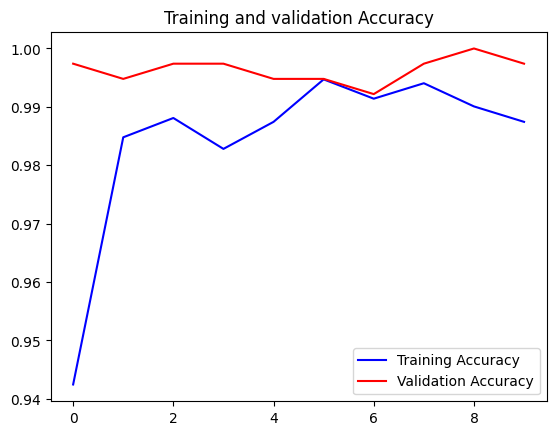

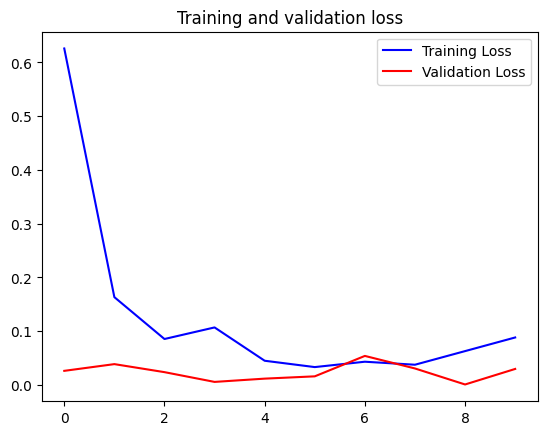

In [8]:
# Plot accuracy dan loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.legend()

plt.figure()


plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Langkah 7: Menguji Performa Model

Menggunakan dataset pengujian untuk mengukur akurasi dan loss model.

1. **Evaluasi Model:**
   - Fungsi **evaluate** mengukur **loss** dan **akurasi** pada data pengujian.
   - **steps** disesuaikan dengan ukuran dataset dan batch size.

2. **Menampilkan Hasil:**
   - Menampilkan **test loss** dan **test akurasi** untuk mengevaluasi kinerja model.

Langkah ini menilai kemampuan model dalam mengklasifikasikan data pengujian.


In [9]:
# Test performa model
test_pred = model.evaluate(test_set,
                          steps=test_set.n // batch_size,
                          verbose=1)

print('Test loss: ', test_pred[0])
print('Test akurasi: ', test_pred[1])

10/10 [==============================] - 6s 537ms/step - loss: 0.0516 - accuracy: 0.9906
Test loss:  0.05157186836004257
Test akurasi:  0.9906250238418579


## Langkah 8: Menghitung dan Menampilkan Matriks Confusion

Menghitung dan menampilkan matriks confusion untuk mengevaluasi kinerja model pada data pengujian.

1. **Prediksi pada Data Pengujian:** Menggunakan **predict** untuk mendapatkan prediksi probabilitas.
2. **Mengubah Probabilitas ke Klasifikasi:** Prediksi dikonversi menjadi label biner dengan ambang 0.5.
3. **Menghitung Matriks Confusion:** Menggunakan **confusion_matrix** untuk membandingkan prediksi dan label asli.
4. **Visualisasi Matriks Confusion:** Menampilkan matriks menggunakan **seaborn heatmap**.

Langkah ini membantu menilai akurasi klasifikasi model.


327/327 [==============================] - 10s 27ms/step


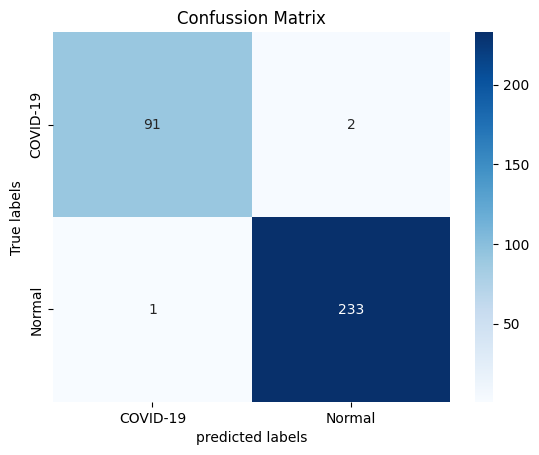

In [10]:
test_pred = model.predict(test_set,
                          steps=test_set.n,
                          verbose=1)
    
test_pred_matrixz = (test_pred >= 0.5).astype(int)

cm = confusion_matrix(test_set.classes, test_pred_matrixz)

ax=plt.subplot()
sns.heatmap(cm, annot=True, ax=ax, fmt='d', cmap='Blues')

ax.set_xlabel('predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confussion Matrix')
ax.set_xticklabels(['COVID-19', 'Normal'])
ax.set_yticklabels(['COVID-19', 'Normal'])
plt.show()

Salah memprediksi 2 gambar COVID-19 sebagai Normal. <br>
Salah memprediksi 1 gambar Normal sebagai COVID-19.

## Langkah 9: Menampilkan Laporan Klasifikasi (Classification Report)

Pada langkah ini, kita menghasilkan **classification report** untuk menilai kinerja model dengan metrik **precision**, **recall**, **f1-score**, dan **support**.

### Penjelasan Langkah:

1. **Menggunakan classification_report:**
   - Fungsi **classification_report** menghitung metrik berdasarkan label asli (`test_set.classes`) dan prediksi model (`test_pred_matrixz`).
   - Metrik yang dihitung:
     - **Precision:** Rasio prediksi benar yang positif terhadap seluruh prediksi positif.
     - **Recall:** Rasio prediksi benar yang positif terhadap seluruh sampel yang benar-benar positif.
     - **F1-Score:** Rata-rata harmonis antara precision dan recall.
     - **Support:** Jumlah contoh sebenarnya dalam setiap kelas.

Laporan ini memberikan gambaran mendalam tentang kinerja model pada setiap kelas.


In [11]:
# classification report
print(classification_report(test_set.classes, test_pred_matrixz))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98        93
           1       0.99      1.00      0.99       234

    accuracy                           0.99       327
   macro avg       0.99      0.99      0.99       327
weighted avg       0.99      0.99      0.99       327



## Test

In [35]:
import tkinter as tk
from tkinter import filedialog

# Gunakan file dialog untuk memilih file
root = tk.Tk()
root.withdraw()  # Sembunyikan jendela utama
file_path = filedialog.askopenfilename()

if file_path:
    print(f"File yang dipilih: {file_path}")


File yang dipilih: D:/covid-chestxray-dataset-master/images/000001-1.jpg


In [36]:
training_set.class_indices

{'covid': 0, 'normal': 1}

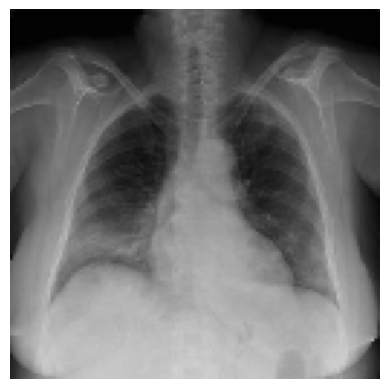

1/1 [==============================] - 0s 92ms/step
Prediksi: Gambar ini adalah X-ray COVID-19


In [31]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np

# Load gambar dan sesuaikan ukuran
img = image.load_img(file_path, target_size=(128, 128))  # Sesuaikan dengan input model Anda

plt.imshow(img)
plt.axis('off')
plt.show()

# Preproses gambar
x = image.img_to_array(img)
x = x / 255.0
x = np.expand_dims(x, axis=0)

# Prediksi dengan model
prediction = model.predict(x)

# Tampilkan hasil prediksi
if prediction[0][0] > 0.5:
    print("Prediksi: Gambar ini adalah X-ray NORMAL")
else:
    print("Prediksi: Gambar ini adalah X-ray COVID-19")
